# Классификация автомобилей по их фото¶


Добавлена более продвинутая библиотека аугментации изображений - albumentations. Для нее есть специальные «обёртки» под Keras, например ImageDataAugmentor.

In [33]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [34]:
pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-zuf4oc63
Note: you may need to restart the kernel to use updated packages.


### Импорт библиотек

In [35]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['sf-dl-car-classification']
Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.17.5
Tensorflow   : 2.3.1
Keras        : 2.4.0


### Основные настройки

In [37]:
EPOCHS               = 5  # количество эпох на обучение
BATCH_SIZE           = 64 # batch - требует уменьшения, если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4 # скорость обучения
VAL_SPLIT            = 0.15 # объем тестовых данных - 15%
CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # размер изображения, подаваемого в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [38]:
DATA_PATH = '/kaggle/input/sf-dl-car-classification/'
PATH = "/kaggle/working/car/"

In [39]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

In [40]:
train_df = pd.read_csv(DATA_PATH+"train.csv")

In [41]:
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")

In [42]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DATA_PATH + data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


## Подготовка данных

### Аугментация данных

In [43]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=224, width=200),
        albumentations.CenterCrop(height=200, width=224),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])



In [44]:
train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT)
        
test_datagen = ImageDataAugmentor(rescale=1./255)

### Генерация данных

Заворачиваем данные в генератор:

In [45]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с фото 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


Для сабмита мы используем другой источник test_datagen.flow_from_dataframe, так как нам нужно дать предсказание с привязкой к конкретному Id картинки из dataframe.

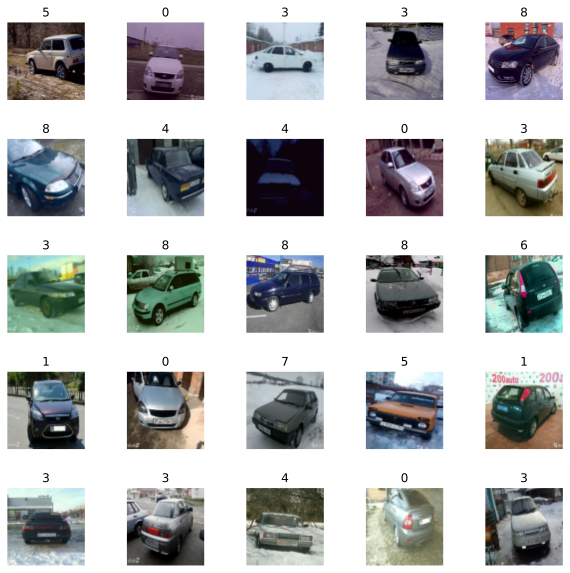

In [46]:
train_generator.show_data()

## Построение модели

### Загрузка предобученной сети Xception

In [47]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [48]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

### Установка новой "головы"

In [49]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [50]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

### Обучение модели

Добавим ModelCheckpoint. Эта функция позволяет сохранять прогресс обучения модели, чтобы в нужный момент можно было его подгрузить и дообучить модель.

In [51]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

Обучение:

In [52]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/5
207/207 [==============================] - ETA: 0s - loss: 0.9142 - accuracy: 0.6812
Epoch 00001: saving model to best_model.hdf5
207/207 [==============================] - 202s 974ms/step - loss: 0.9142 - accuracy: 0.6812 - val_loss: 0.3870 - val_accuracy: 0.8609
Epoch 2/5
207/207 [==============================] - ETA: 0s - loss: 0.2357 - accuracy: 0.9174
Epoch 00002: saving model to best_model.hdf5
207/207 [==============================] - 199s 962ms/step - loss: 0.2357 - accuracy: 0.9174 - val_loss: 0.2762 - val_accuracy: 0.9060
Epoch 3/5
207/207 [==============================] - ETA: 0s - loss: 0.1547 - accuracy: 0.9443
Epoch 00003: saving model to best_model.hdf5
207/207 [==============================] - 200s 968ms/step - loss: 0.1547 - accuracy: 0.9443 - val_loss: 0.2022 - val_accuracy: 0.9326
Epoch 4/5
207/207 [==============================] - ETA: 0s - loss: 0.1063 - accuracy: 0.9611
Epoch 00004: saving model to best_model.hdf5
207/207 [==========================

Сохранение итоговой сети и подгрузка лучшей итерации в обучении (best_model):

In [53]:
model.save('/kaggle/working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [54]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

37/37 [==============================] - 22s 604ms/step - loss: 0.2528 - accuracy: 0.9163
Accuracy: 91.63%


Точность модели составила 91,63 %. 

### Графики обучения

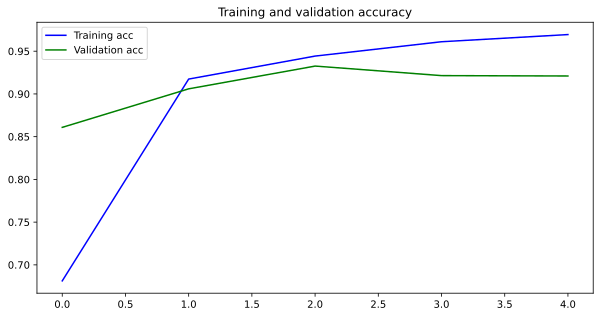

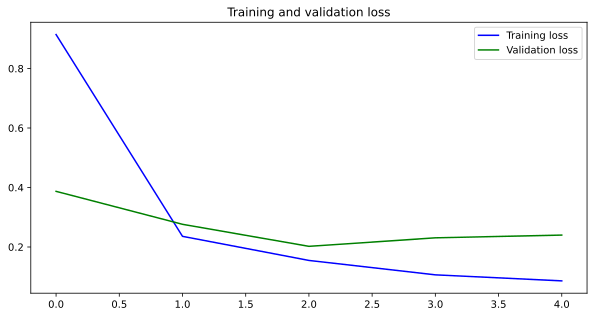

In [55]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

## Предсказание на тестовых данных

In [56]:
test_sub_generator.samples

6675

In [57]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

105/105 [==============================] - 45s 431ms/step


In [58]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [59]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,7


Результат на kaggle улучшился более, чем на 0.5% - 0.94127